In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Plotting functions

In [2]:
def plot_within_hour(df, year, month, day, hour, metric, devices):
    """
    Plots the specified metric over the specified hour for the given devices.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year of the hour to plot.
    - month (int): The month of the hour to plot.
    - day (int): The day of the hour to plot.
    - hour (int): The hour (in 24-hour format) to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.

    Returns:
    - None: Displays the plot.

    Raises:
    - ValueError: If any device in 'devices' is not found in the DataFrame.
    - ValueError: If the 'metric' is not present in the DataFrame.
    """

    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present in the DataFrame
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter for the specified devices
    df_filtered = df[df["label"].isin(devices)]

    # Create a datetime range for the specified hour
    start_time = pd.Timestamp(year, month, day, hour)
    end_time = start_time + pd.Timedelta(hours=1)

    # Filter the DataFrame for the specified hour
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    # Handle missing values in the metric column
    df_filtered = df_filtered.dropna(subset=[metric])

    # Plot the data
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_filtered, x="time", y=metric, hue="label", marker="o")

    # Set plot title and labels
    plt.title(f"{metric} over time on {year}-{month:02d}-{day:02d} Hour {hour:02d}")
    plt.xlabel("Time")
    plt.ylabel(metric.capitalize())

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Move the legend outside the plot
    plt.legend(title="Device Label", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_within_day(df, year, month, day, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each hour within the specified day.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - day (int): The day to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.

    Returns:
    - None: Displays the plot.
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by date
    start_time = pd.Timestamp(year, month, day)
    end_time = start_time + pd.Timedelta(days=1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])

    # Extract hour
    df_filtered["hour"] = df_filtered["time"].dt.hour

    # Group by hour and label
    df_grouped = (
        df_filtered.groupby(["hour", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["hour"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["hour"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )

    plt.title(f"{metric} over each hour on {year}-{month:02d}-{day:02d}")
    plt.xlabel("Hour")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(0, 24))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_month(df, year, month, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each day within the specified month.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.

    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by month
    start_time = pd.Timestamp(year, month, 1)
    if month == 12:
        end_time = pd.Timestamp(year + 1, 1, 1)
    else:
        end_time = pd.Timestamp(year, month + 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])

    # Extract day
    df_filtered["day"] = df_filtered["time"].dt.day

    # Group by day and label
    df_grouped = (
        df_filtered.groupby(["day", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["day"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["day"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )

    plt.title(f"{metric} over each day in {year}-{month:02d}")
    plt.xlabel("Day")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 32))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_year(df, year, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each month within the specified year.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.

    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by year
    start_time = pd.Timestamp(year, 1, 1)
    end_time = pd.Timestamp(year + 1, 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])

    # Extract month
    df_filtered["month"] = df_filtered["time"].dt.month

    # Group by month and label
    df_grouped = (
        df_filtered.groupby(["month", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["month"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["month"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )

    plt.title(f"{metric} over each month in {year}")
    plt.xlabel("Month")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 13))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Preprocessing

In [3]:
wifistats_df = pd.read_csv("./data/wifistats.csv")
extra_info_df = pd.read_csv("./data/extra_info.csv")
devices_df = pd.read_csv("./data/devices.csv")

df = pd.merge(wifistats_df, extra_info_df, on="label", how="inner")
df.head()

,label,time,signal (dBm),packet_loss,connected_time (s),tx_bitrate (MBit/s),rx_bitrate (MBit/s),min_ping_rtt (ms),avg_ping_rtt (ms),max_ping_rtt (ms),mdev_ping_rtt (ms),latitude,longitude
0,raspi-e4:5f:01:72:a4:93,2023-10-27 17:30:59.941150,-61.0,0.0,1483.0,180.0,180.0,3.151,4.908,5.733,0.970,34.409854,-119.85204
1,raspi-e4:5f:01:72:a4:93,2023-10-27 17:41:15.676388,-61.0,0.0,2097.0,180.0,180.0,2.951,3.133,3.474,0.180,34.409854,-119.85204
2,raspi-e4:5f:01:72:a4:93,2023-10-27 17:51:31.517963,-61.0,0.0,2712.0,180.0,150.0,3.445,6.585,16.535,4.994,34.409854,-119.85204
3,raspi-e4:5f:01:72:a4:93,2023-10-27 18:01:47.322451,-61.0,0.0,3327.0,200.0,180.0,4.669,6.734,10.152,1.827,34.409854,-119.85204
4,raspi-e4:5f:01:72:a4:93,2023-10-27 18:12:13.192403,-60.0,0.0,3942.0,200.0,180.0,4.893,6.195,7.588,0.870,34.409854,-119.85204


# Example

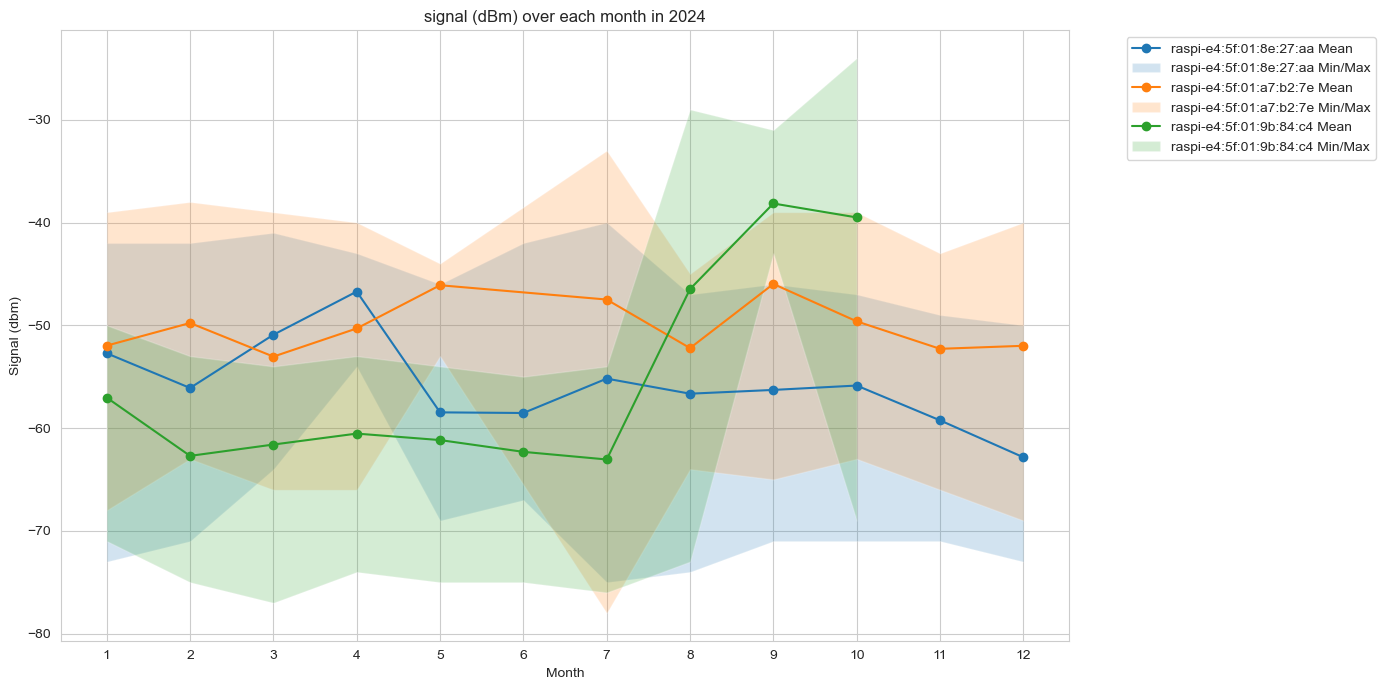

In [4]:
# signal strength over time in 2024
plot_within_year(
    df,
    2024,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)

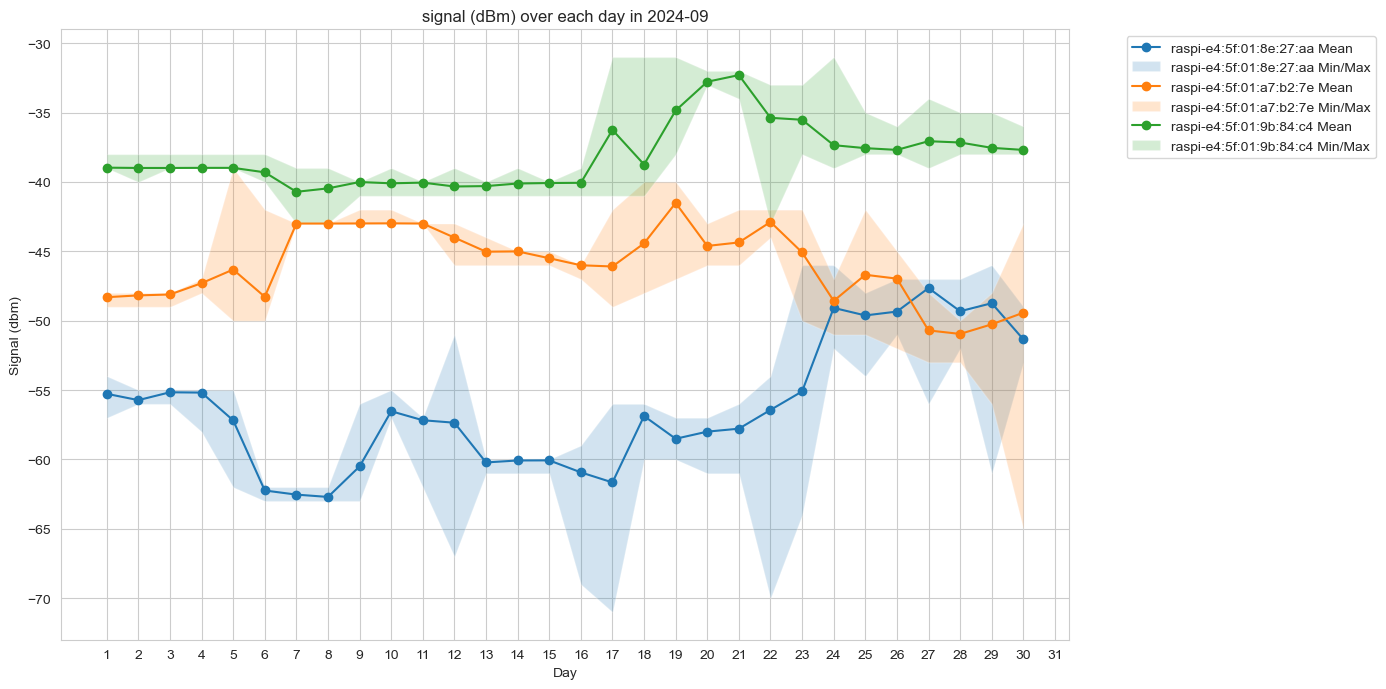

In [5]:
# signal strength over time in the September, 2024
plot_within_month(
    df,
    2024,
    9,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)

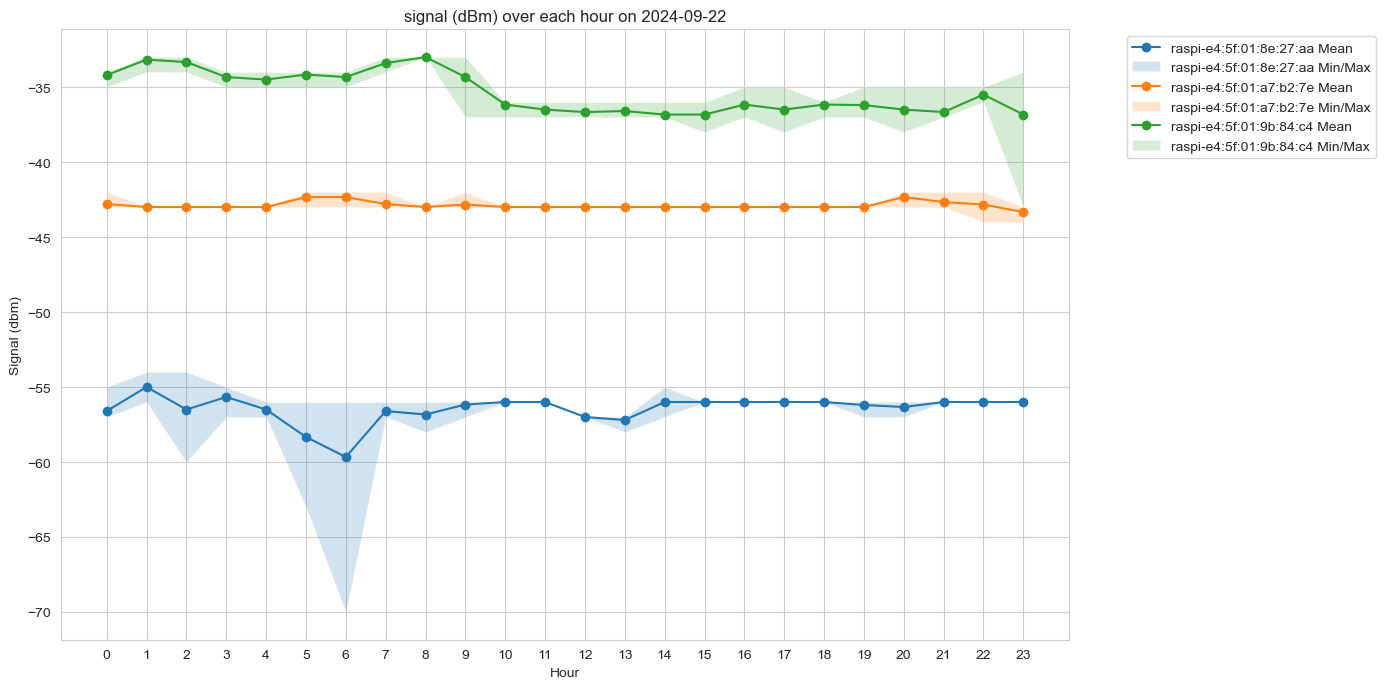

In [6]:
# signal strength over time in September 22, 2024
plot_within_day(
    df,
    2024,
    9,
    22,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)

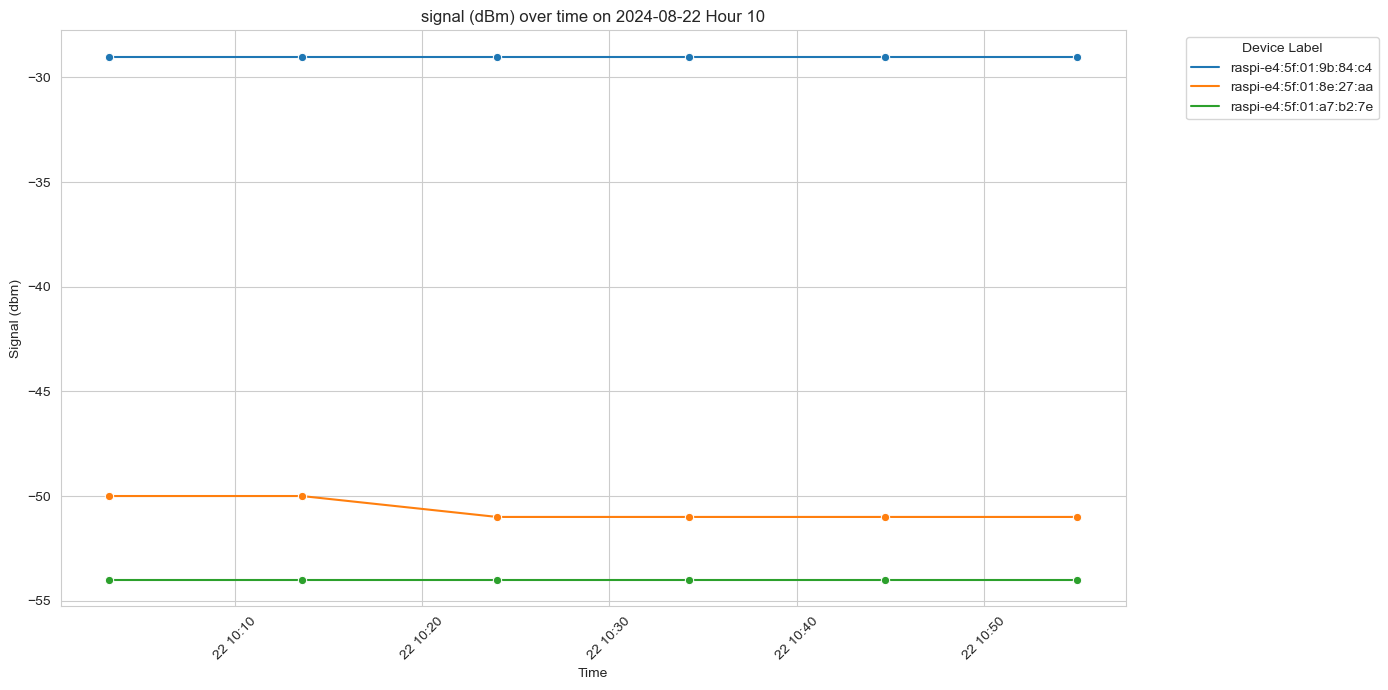

In [7]:
# signal strength over time in 10:00 AM, September 22, 2024
plot_within_hour(
    df,
    2024,
    8,
    22,
    10,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)

# Grouping Device Data

In [8]:
center_lat = extra_info_df["latitude"].mean()
center_long = extra_info_df["longitude"].mean()

m = folium.Map(location=[center_lat, center_long], zoom_start=14)

for _, row in extra_info_df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=row["label"],
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(m)

m.save("./data/map.html")
display(m)

In [9]:
# Manually inputted
location_to_label = {
    "San Joaquin": [
        "raspi-e4:5f:01:9c:ca:3a",
        "raspi-e4:5f:01:a7:b2:7b",
        "raspi-e4:5f:01:a0:4f:96",
        "raspi-e4:5f:01:72:a3:1c",
        "raspi-e4:5f:01:a7:b1:a3",
        "raspi-e4:5f:01:72:a2:35",
        "raspi-e4:5f:01:9b:85:9c",
        "raspi-e4:5f:01:a7:b1:9d",
    ],
    "West Campus": ["raspi-e4:5f:01:6f:ed:f3"],
    "San Clemente": [
        "raspi-e4:5f:01:72:a2:eb",
        "raspi-e4:5f:01:56:d9:a3",
        "raspi-e4:5f:01:75:54:04",
        "raspi-e4:5f:01:56:d8:f3",
        "raspi-e4:5f:01:75:6b:2c",
    ],
    "Student Resource Building": [
        "raspi-e4:5f:01:a7:b1:e2",
        "raspi-e4:5f:01:75:6a:df",
        "raspi-e4:5f:01:a7:b1:e5",
        "raspi-e4:5f:01:ad:c9:11",
        "raspi-e4:5f:01:a0:50:5f",
    ],
    "Henley Hall": ["raspi-e4:5f:01:ad:c9:3f"],
    "Harold Frank Hall": ["raspi-e4:5f:01:84:8c:99"],
    "San Miguel": ["raspi-e4:5f:01:8d:07:57"],
    "San Nicolas": ["raspi-e4:5f:01:9b:84:fa"],
    "Manzanita": [
        "raspi-e4:5f:01:a0:4b:01",
        "raspi-e4:5f:01:a0:4e:31",
        "raspi-e4:5f:01:9c:24:87",
        "raspi-e4:5f:01:a7:ae:70",
        "raspi-e4:5f:01:a0:4f:9f",
        "raspi-e4:5f:01:72:a4:93",
        "raspi-e4:5f:01:96:01:e8",
        "raspi-e4:5f:01:8d:f5:95",
        "raspi-e4:5f:01:8e:27:aa",
        "raspi-e4:5f:01:a7:b2:7e",
        "raspi-e4:5f:01:84:7f:76",
        "raspi-e4:5f:01:a0:34:a5",
        "raspi-e4:5f:01:9c:20:81",
        "raspi-e4:5f:01:75:54:ec",
        "raspi-e4:5f:01:a0:4a:77",
        "raspi-e4:5f:01:a7:b1:c1",
        "raspi-e4:5f:01:8d:ca:31",
        "raspi-e4:5f:01:a0:4a:dd",
        "raspi-e4:5f:01:a0:21:49",
        "raspi-e4:5f:01:ad:c9:2a",
        "raspi-e4:5f:01:8d:ca:12",
        "raspi-e4:5f:01:78:6f:2e",
        "raspi-e4:5f:01:88:c4:99",
        "raspi-e4:5f:01:9b:84:c4",
        "raspi-e4:5f:01:a7:b1:af",
        "raspi-e4:5f:01:8c:8a:41",
        "raspi-e4:5f:01:ac:e5:4b",
        "raspi-e4:5f:01:a0:32:5f",
        "raspi-e4:5f:01:a0:4f:c5",
        "raspi-e4:5f:01:9c:25:7d",
        "raspi-e4:5f:01:8d:ca:34",
        "raspi-e4:5f:01:ac:ed:5b",
        "raspi-e4:5f:01:6f:ee:14",
        "raspi-e4:5f:01:ad:c9:04",
    ],
}

# Analyzing San Joaquin

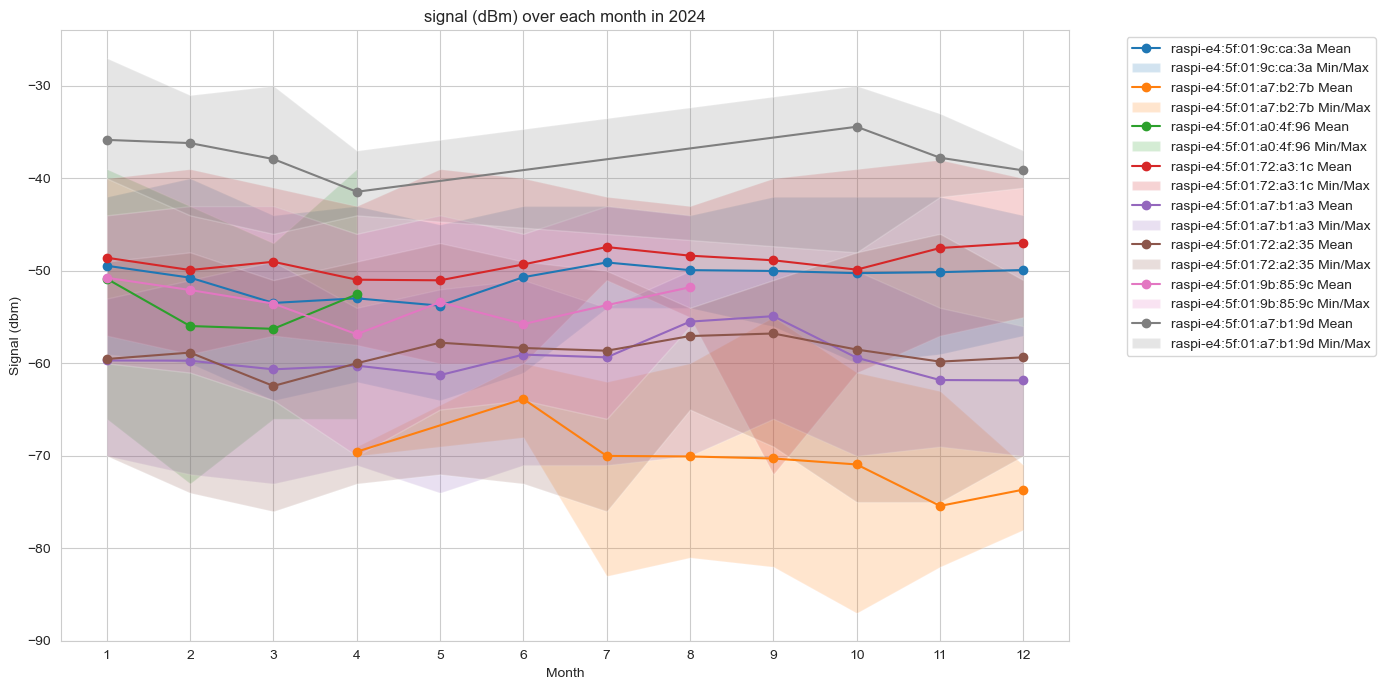

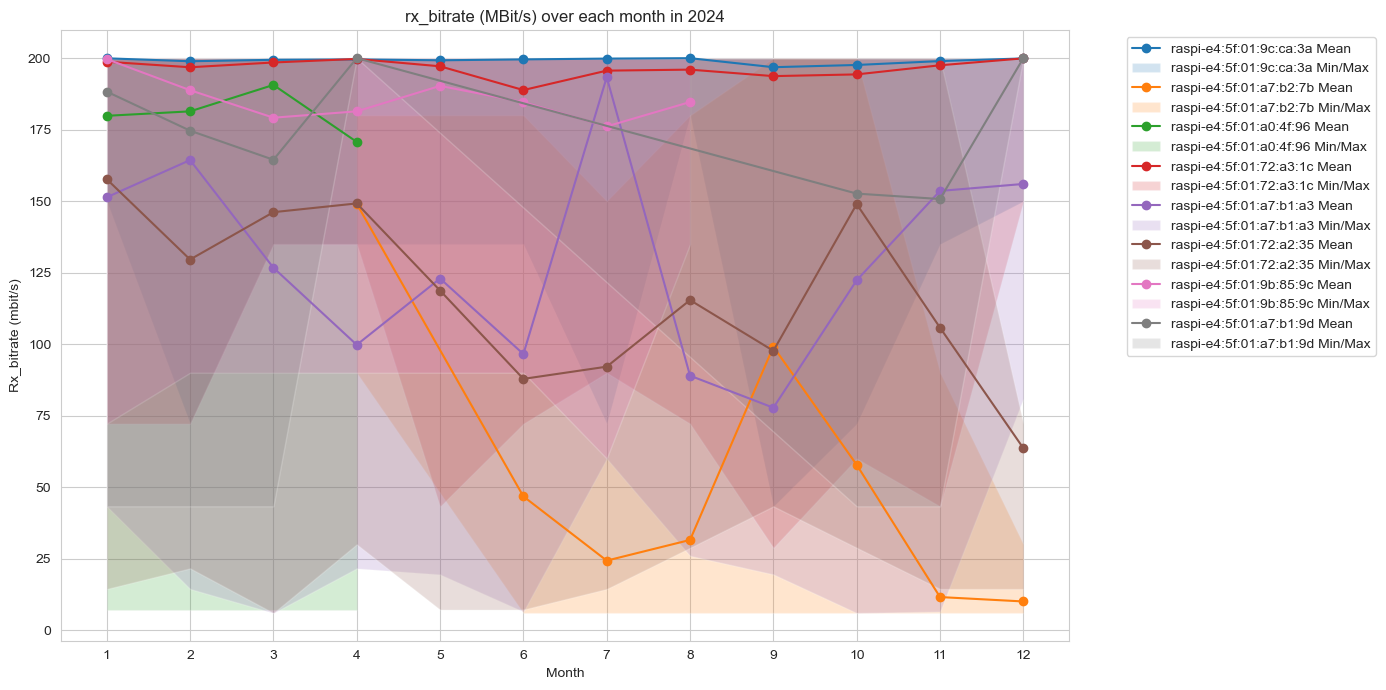

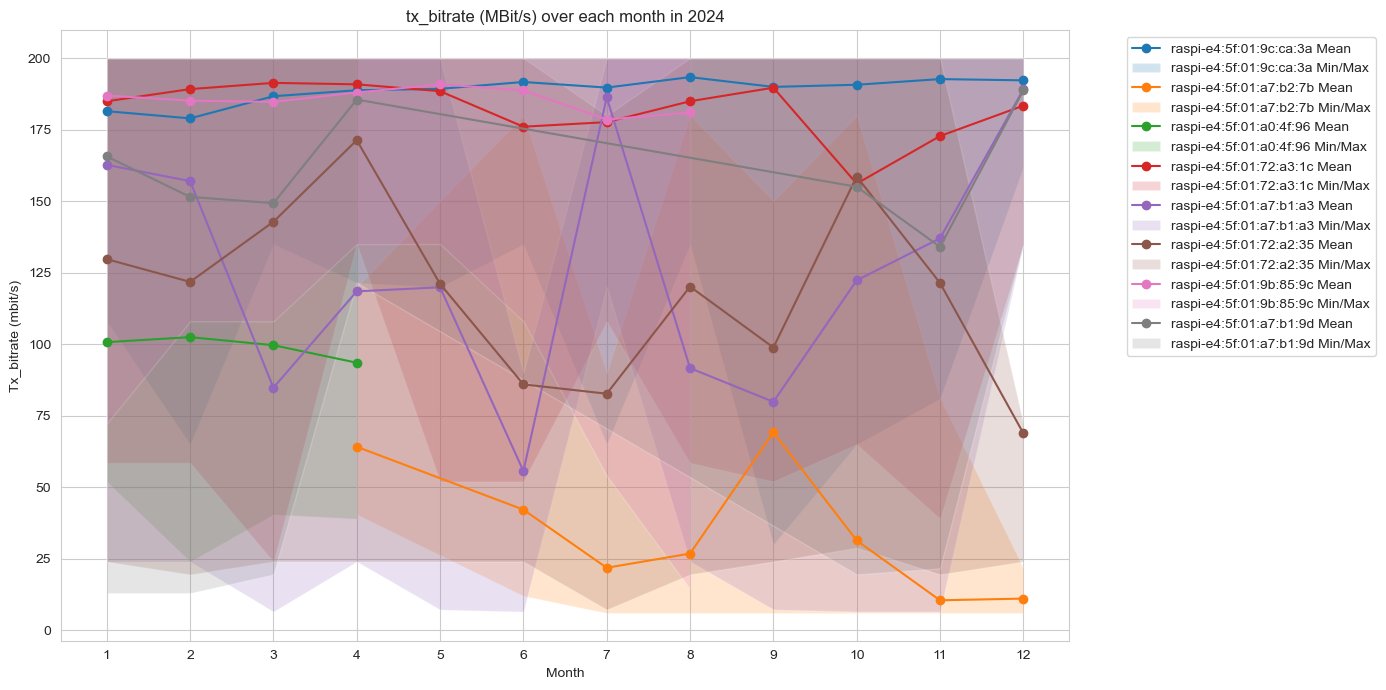

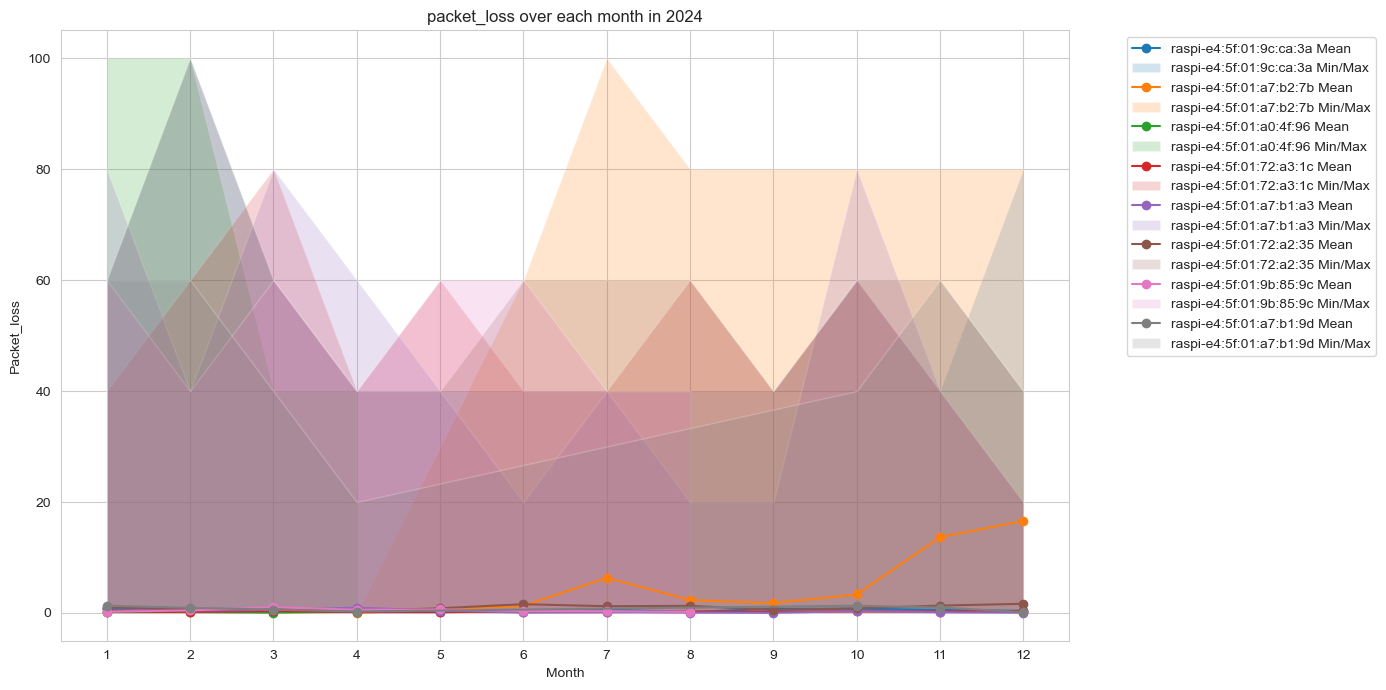

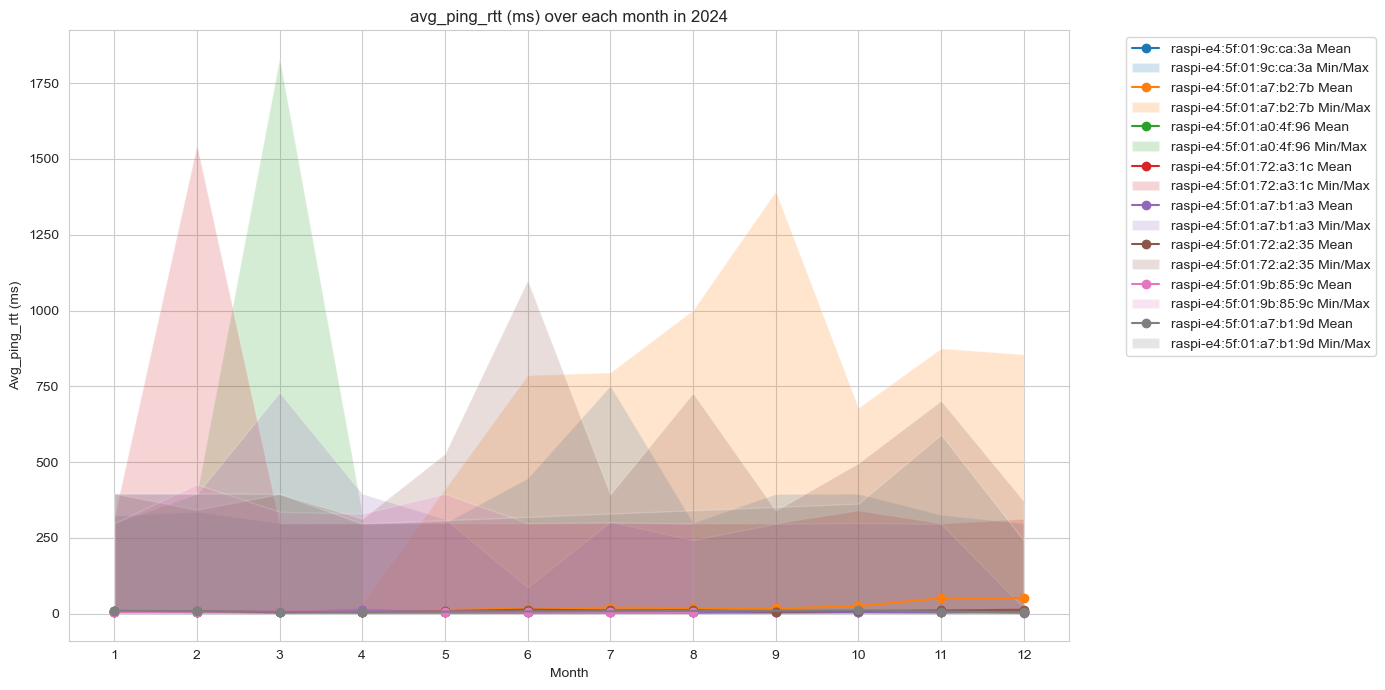

In [19]:
plot_within_year(
    df,
    2024,
    "signal (dBm)",
    location_to_label["San Joaquin"],
)
plot_within_year(
    df,
    2024,
    "rx_bitrate (MBit/s)",
    location_to_label["San Joaquin"],
)
plot_within_year(
    df,
    2024,
    "tx_bitrate (MBit/s)",
    location_to_label["San Joaquin"],
)
plot_within_year(
    df,
    2024,
    "packet_loss",
    location_to_label["San Joaquin"],
)
plot_within_year(
    df,
    2024,
    "avg_ping_rtt (ms)",
    location_to_label["San Joaquin"],
)

## Insights and Analysis

Most devices in the San Joaquin area have overall good network performance. We see a majority of the devices' signal strength be around -50 dBm to -60 dBm which is very good. Packet loss is very minimum and overall ping is very low.

However, there are some outliers that we noticed. Device "raspi-e4:5f:01:a7:b2:7b", which is located in the upper part of the San Joaquin Tower Villages, has noticably bad network performance. It has much worse signal strength and much lower tx and rx bitrate compared to other devices in the San Joaquin area. It has had decently high packet loss in the more recent months this year. Since this device is located near a student study room, we'd recommend reducing the distance between an access point with this device (add another access point).

Furthermore, we noticed that the devices "raspi-e4:5f:01:72:a2:35", located in the center of the right portion of the San Joaquin North Villages, and "raspi-e4:5f:01:a7:b1:a3", located just west of the Santa Catalina North Tower, had very variable over the year. Since these devices are located in the center of zones with lots of students and thus devices, we'd recommend improving the stability of network performance at these locations.
